This notebook checks that the reference results for the `ipDataToPointCloud` tool are correct.

In [1]:
import numpy as np
import pyvista as pv

In [2]:
def check_ip_data(mesh, point_cloud, field_name):
    # kept name "sigma_ip", although it might also be "epsilon_ip" or something completely different
    sigma_ip_field = mesh.field_data[field_name]
    sigma_ip_point = point_cloud.point_data[field_name]

    num_ips = sigma_ip_field.shape[0]

    # check that each IP corresponds to a point in the point cloud
    assert num_ips == point_cloud.n_points

    # check that values of sigma_ip are equal
    assert np.allclose(sigma_ip_field, sigma_ip_point, atol=1e-15, rtol=0)


def check_all_points_enclosed_by_mesh_surface_3D(mesh, point_cloud):
    surface = mesh.extract_surface()
    points_in_mesh = point_cloud.select_enclosed_points(surface)

    # check that each point in the point cloud is contained in the "original" mesh
    assert points_in_mesh.n_points == point_cloud.n_points


def check_all_points_inside_bbox_2D(mesh, point_cloud):
    xmin, xmax, ymin, ymax, zmin, zmax = mesh.bounds

    assert zmin == 0.0 and zmax == 0.0  # make sure we are in 2D

    assert np.all(point_cloud.points[:, 0] > xmin)
    assert np.all(point_cloud.points[:, 0] < xmax)
    assert np.all(point_cloud.points[:, 1] > ymin)
    assert np.all(point_cloud.points[:, 1] < ymax)

# Mixed element test

In [3]:
mesh = pv.read("mesh_with_3D_different_elements_sigma_ip.vtu")
point_cloud = pv.read("mesh_with_3D_different_elements_sigma_ip_point_cloud.vtu")

check_ip_data(mesh, point_cloud, "sigma_ip")
check_all_points_enclosed_by_mesh_surface_3D(mesh, point_cloud)

# Tri and quad mesh test

In [4]:
mesh = pv.read("TriQuad/quad_tri_THM_t_864000_000000.vtu")
point_cloud = pv.read("TriQuad/quad_tri_THM_t_864000_000000_point_cloud.vtu")

check_ip_data(mesh, point_cloud, "sigma_ip")
check_ip_data(mesh, point_cloud, "epsilon_ip")

check_all_points_inside_bbox_2D(mesh, point_cloud)

# m1_3Dsquare test

In [5]:
def set_integration_order_to_3(path):
    mesh = pv.read(path)

    import json

    ip_meta_str = bytes(mesh.field_data["IntegrationPointMetaData"]).decode("utf-8")
    ip_meta = json.loads(ip_meta_str)
    ip_meta["integration_point_arrays"][0]["integration_order"] = 3
    ip_meta
    ip_meta_str = json.dumps(ip_meta)
    ip_meta_str.encode("utf-8")

    mesh.field_data["IntegrationPointMetaData"] = np.frombuffer(
        ip_meta_str.encode("utf-8"), dtype=np.int8
    )

    mesh.save(path)


# Before 2022-10 the integration point meta data was wrong.
# This function can be used to correct it.
# set_integration_order_to_3("../../../Mechanics/m1_3Dsquare/m1_3Dsquare_ts_1_t_1.000000.vtu")

In [6]:
mesh = pv.read("../../../Mechanics/m1_3Dsquare/m1_3Dsquare_ts_1_t_1.000000.vtu")
point_cloud = pv.read(
    "../../../Mechanics/m1_3Dsquare/m1_3Dsquare_ts_1_t_1.000000_point_cloud.vtu"
)

check_ip_data(mesh, point_cloud, "sigma_ip")
check_all_points_enclosed_by_mesh_surface_3D(mesh, point_cloud)

## Check linear stress distribution

In [8]:
import matplotlib.pyplot as plt

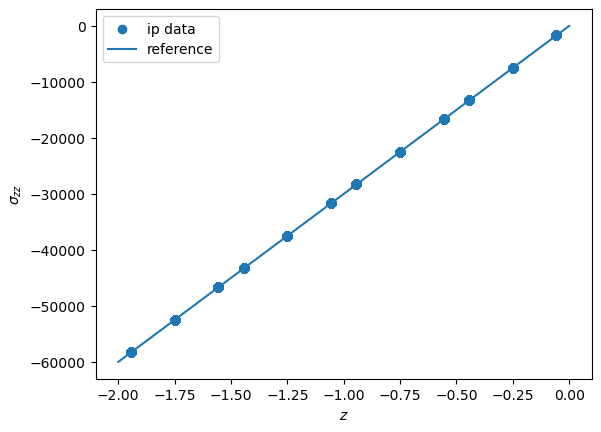

In [9]:
fig, ax = plt.subplots()

sigs_ip = point_cloud.point_data["sigma_ip"]
sigs_ip_zz = sigs_ip[:, 2]
zs_ip = point_cloud.points[:, 2]

ax.scatter(zs_ip, sigs_ip_zz, label="ip data")

zs_ref = np.linspace(-2, 0)
sigs_zz_ref = 3e4 * zs_ref

ax.plot(zs_ref, sigs_zz_ref, label="reference")

ax.legend()
ax.set_ylabel(r"$\sigma_{zz}$")
ax.set_xlabel("$z$")

In [10]:
# sigma_zz ranges between 0 and -60000, so an absolute tolerance of 0.4 or 0.65 is OK
assert np.allclose(sigs_ip[:, [0, 1, 3, 4, 5]], 0, atol=0.4, rtol=0)
assert np.allclose(
    sigs_ip_zz, 3e4 * zs_ip, atol=0.65, rtol=0
)  # shows that the z order of the points in the point cloud are not messed up